## 准备工作
使用通义灵码api ，重构embedding.ipynb

1.确保您按照[README](README-CN.md)中的说明在环境中设置了API密钥

2.安装依赖包

In [1]:
%pip install tiktoken openai pandas matplotlib plotly scikit-learn numpy

Looking in indexes: https://mirrors.aliyun.com/pypi/simple

[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [19]:
%pip install -U dashscope

Looking in indexes: https://mirrors.aliyun.com/pypi/simple
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 34.8 MB/s eta 0:00:00

[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [20]:
%pip install -U openai

Looking in indexes: https://mirrors.aliyun.com/pypi/simple
  Attempting uninstall: openai
    Found existing installation: openai 1.60.0
    Uninstalling openai-1.60.0:
      Successfully uninstalled openai-1.60.0

[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
print('hello world')

hello world


## 1. 生成 Embedding (基于通义大模型api)

嵌入对于处理自然语言和代码非常有用，因为其他机器学习模型和算法（如聚类或搜索）可以轻松地使用和比较它们。

![Embedding](images/embedding-vectors.svg)

### 亚马逊美食评论数据集(amazon-fine-food-reviews)

Source:[美食评论数据集](https://www.kaggle.com/snap/amazon-fine-food-reviews)

![dataset](images/amazon-fine-food-reviews.png)


该数据集包含截至2012年10月用户在亚马逊上留下的共计568,454条美食评论。为了说明目的，我们将使用该数据集的一个子集，其中包括最近1,000条评论。这些评论都是用英语撰写的，并且倾向于积极或消极。每个评论都有一个产品ID、用户ID、评分、标题（摘要）和正文。

我们将把评论摘要和正文合并成一个单一的组合文本。模型将对这个组合文本进行编码，并输出一个单一的向量嵌入。

In [6]:
# 导入 pandas 包。Pandas 是一个用于数据处理和分析的 Python 库
# 提供了 DataFrame 数据结构，方便进行数据的读取、处理、分析等操作。
import pandas as pd

# 导入 tiktoken 库。Tiktoken 是 OpenAI 开发的一个库，用于从模型生成的文本中计算 token 数量。
import tiktoken

#### 加载数据集

In [7]:
input_datapath = "data/fine_food_reviews_1k.csv"
df = pd.read_csv(input_datapath, index_col=0)
df = df[["Time", "ProductId", "UserId", "Score", "Summary", "Text"]]
df = df.dropna()

# 将 "Summary" 和 "Text" 字段组合成新的字段 "combined"
df["combined"] = (
    "Title: " + df.Summary.str.strip() + "; Content: " + df.Text.str.strip()
)
df.head(2)

,Time,ProductId,UserId,Score,Summary,Text,combined
0,1351123200,B003XPF9BO,A3R7JR3FMEBXQB,5,where does one start...and stop... with a tre...,Wanted to save some to bring to my Chicago fam...,Title: where does one start...and stop... wit...
1,1351123200,B003JK537S,A3JBPC3WFUT5ZP,1,Arrived in pieces,"Not pleased at all. When I opened the box, mos...",Title: Arrived in pieces; Content: Not pleased...


In [8]:
df["combined"]

0      Title: where does one  start...and stop... wit...
1      Title: Arrived in pieces; Content: Not pleased...
2      Title: It isn't blanc mange, but isn't bad . ....
3      Title: These also have SALT and it's not sea s...
4      Title: Happy with the product; Content: My dog...
                             ...                        
995    Title: Delicious!; Content: I have ordered the...
996    Title: Good Training Treat; Content: My dog wi...
997    Title: Jamica Me Crazy Coffee; Content: Wolfga...
998    Title: Party Peanuts; Content: Great product f...
999    Title: I love Maui Coffee!; Content: My first ...
Name: combined, Length: 1000, dtype: object

#### Embedding 模型关键参数

In [9]:
# 这是通义千问的模型调用
# 模型类型
embedding_model = "text-embedding-v3"
# 在我们的 DEMO 中过滤 Token 超过 8000 的文本
max_tokens = 8000  

#### 将样本减少到最近的1,000个评论，并删除过长的样本


In [10]:
# 设置要筛选的评论数量为1000
top_n = 1000
# 对DataFrame进行排序，基于"Time"列，然后选取最后的2000条评论
df = df.sort_values("Time").tail(top_n * 2) 

# 丢弃"Time"列，因为我们在这个分析中不再需要它
df.drop("Time", axis=1, inplace=True)

# 直接使用字符长度作为粗略的token数量估计
# 中文一般1个字符≈1个token，英文一般1个单词≈1-2个token
df["n_tokens"] = df.combined.apply(lambda x: len(x))

# 使用保守的阈值（比如max_tokens的80%）来过滤文本
safe_max_tokens = int(max_tokens * 0.8)  # 设置一个安全阈值
df = df[df.n_tokens <= safe_max_tokens].tail(top_n)

# 打印出剩余评论的数量
len(df)

1000

In [11]:
# 设置要筛选的评论数量和最大token限制
top_n = 1000
max_tokens = 8000  # 通义千问v3模型最大支持8192，我们设置8000作为安全值

# 直接取最后1000条评论
df = df.tail(top_n)

# 使用字符长度作为粗略的token数量估计
df["n_tokens"] = df.combined.apply(lambda x: len(x))

# 过滤掉预估token数量超过最大限制的评论
df = df[df.n_tokens <= max_tokens]

#### 生成 Embeddings 并保存


In [12]:
from openai import OpenAI
from dotenv import load_dotenv
import os

In [13]:
# OpenAI Python SDK v1.0 更新后的使用方式
# 这里使用的是通义千问的API
# 加载.env文件中的环境变量
load_dotenv()

# 从环境变量获取API key
api_key = os.getenv('DASHSCOPE_API_KEY')
# 初始化OpenAI客户端
client = OpenAI(
    api_key=api_key,
    base_url="https://dashscope.aliyuncs.com/compatible-mode/v1"
)

In [14]:
# 新版本创建 Embedding 向量的方法
# Ref：https://community.openai.com/t/embeddings-api-documentation-needs-to-updated/475663
res = client.embeddings.create(input="abc", model=embedding_model)
print(res.data[0].embedding)

[-0.025253048166632652, 0.0386127233505249, -0.074822336435318, 0.0174836628139019, -0.05559743568301201, -0.04675886780023575, 0.010936198756098747, 0.010355786420404911, 0.034234173595905304, 0.029183562844991684, 0.005595382768660784, 0.0032228182535618544, -0.0071889725513756275, -0.03162740543484688, 0.019856227561831474, -0.031586673110723495, -0.016679231077432632, -0.004559295251965523, 0.004027250222861767, -0.05478282272815704, -0.04488525539636612, 0.030079638585448265, -0.01996823586523533, 0.009642998687922955, 0.01001975778490305, 0.09710203856229782, -0.08256117254495621, -0.030548041686415672, -0.02999817579984665, -0.10606279969215393, 0.008945484645664692, -0.005992507562041283, 0.010681631974875927, -0.03103681094944477, 0.007214429322630167, -0.007525000721216202, -0.008044317364692688, -0.013746618293225765, -0.12642815709114075, 0.005284811370074749, 0.008303975686430931, 0.008848749101161957, 0.013094927184283733, -0.03492659330368042, 0.017351288348436356, -0.08

In [15]:
# 使用新方法调用通义千问 Embedding API
def embedding_text(text, model="text-embedding-v3"):
    res = client.embeddings.create(
        input=text, 
        model=model
    )
    return res.data[0].embedding

In [16]:
# 实际生成会耗时几分钟，逐行调用 通义千问 Embedding API

df["embedding"] = df.combined.apply(embedding_text)
output_datapath = "data/fine_food_reviews_with_embeddings_1k_1126.csv"
df.to_csv(output_datapath)

In [17]:
e0 = df["embedding"][0]

In [18]:
e0

[-0.0028806296177208424,
 0.06060419976711273,
 -0.036652032285928726,
 0.0022823079489171505,
 -0.053694549947977066,
 -0.039412032812833786,
 0.002441538730636239,
 0.08090853691101074,
 -0.04763412848114967,
 -0.0402226597070694,
 0.04485482722520828,
 0.041689515113830566,
 -0.043928395956754684,
 -0.02779300883412361,
 0.05975497141480446,
 -0.01697496697306633,
 0.009901260025799274,
 0.00867566466331482,
 -0.0929521769285202,
 -0.08824280649423599,
 -0.042615946382284164,
 0.007652727887034416,
 -0.04697790741920471,
 0.06342210620641708,
 0.02779300883412361,
 0.02956867404282093,
 -0.02225370891392231,
 -0.012265595607459545,
 -0.017746994271874428,
 -0.05307692661881447,
 0.002834790386259556,
 0.012477902695536613,
 0.03487636521458626,
 -0.02746489830315113,
 0.056589655578136444,
 -0.011976084671914577,
 -0.0025935317389667034,
 -0.00755622424185276,
 -0.04500923305749893,
 0.00961657427251339,
 0.014234267175197601,
 0.021057065576314926,
 0.009732378646731377,
 -0.063460

## 2.读取 fine_food_reviews_with_embeddings_1k 嵌入文件

In [20]:
embedding_datapath = "data/fine_food_reviews_with_embeddings_1k.csv"

df_embedded = pd.read_csv(embedding_datapath, index_col=0)

#### 查看 Embedding 结果

In [21]:
df_embedded["embedding"]

12     [-0.0005399271612986922, -0.004124758299440145...
13     [0.0068963742814958096, 0.0167608093470335, -0...
14     [-0.0023715533316135406, -0.021357767283916473...
15     [0.00226533692330122, 0.010306870564818382, 0....
16     [-0.027459919452667236, -0.009041198529303074,...
                             ...                        
447    [0.00796585250645876, 0.0017102764686569571, 0...
436    [0.001777207711711526, -0.011673098430037498, ...
437    [-0.005498920567333698, -0.014834611676633358,...
438    [-0.00294404081068933, -0.007058987859636545, ...
439    [-0.006043732166290283, -0.000693734094966203,...
Name: embedding, Length: 1000, dtype: object

In [22]:
len(df_embedded["embedding"][0])

34410

In [23]:
type(df_embedded["embedding"][0])

str

In [24]:
df_embedded["embedding"][0]

'[0.007060592994093895, -0.02732112631201744, 0.010580576956272125, -0.014588683843612671, 0.004358730278909206, 0.019923659041523933, 0.0006634345045313239, -0.02212364971637726, -0.01926366239786148, -0.013578063808381557, 0.018067417666316032, 0.004080294165760279, -0.032944850623607635, 0.00016059498011600226, 0.015798678621649742, 0.019414912909269333, 0.017888668924570084, -0.026317380368709564, -0.019387412816286087, -0.025107385590672493, -0.047382283955812454, -0.00719809252768755, 0.023828642442822456, -0.008463086560368538, -0.008923709392547607, 0.011433073319494724, 0.02945236675441265, -0.02250864915549755, -0.010174954310059547, 0.02161490172147751, 0.001189369591884315, 0.00905433390289545, -0.013364939950406551, -0.017421171069145203, -0.005912473425269127, -0.01095182541757822, -0.02648238092660904, 0.007328717038035393, 0.022481149062514305, -0.02023990824818611, 0.01907116360962391, -0.015303680673241615, 0.009205583482980728, -0.00831183698028326, 0.001719601568765

In [25]:
import ast

# 将字符串转换为向量
df_embedded["embedding_vec"] = df_embedded["embedding"].apply(ast.literal_eval)

In [26]:
len(df_embedded["embedding_vec"][0])

1536

In [27]:
df_embedded.head(2)

,ProductId,UserId,Score,Summary,Text,combined,n_tokens,embedding,embedding_vec
12,B000K8T3OQ,AK43Y4WT6FFR3,1,Broken in a million pieces,Chips were broken into small pieces. Problem i...,Title: Broken in a million pieces; Content: Ch...,120,"[-0.0005399271612986922, -0.004124758299440145...","[-0.0005399271612986922, -0.004124758299440145..."
13,B0051C0J6M,AWFA8N9IXELVH,1,Deceptive description,On Oct 9 I ordered from a different vendor the...,Title: Deceptive description; Content: On Oct ...,157,"[0.0068963742814958096, 0.0167608093470335, -0...","[0.0068963742814958096, 0.0167608093470335, -0..."


## 3. 使用 t-SNE 可视化 1536 维 Embedding 美食评论

In [28]:
# 导入 NumPy 包，NumPy 是 Python 的一个开源数值计算扩展。这种工具可用来存储和处理大型矩阵，
# 比 Python 自身的嵌套列表（nested list structure)结构要高效的多。
import numpy as np
# 从 matplotlib 包中导入 pyplot 子库，并将其别名设置为 plt。
# matplotlib 是一个 Python 的 2D 绘图库，pyplot 是其子库，提供了一种类似 MATLAB 的绘图框架。
import matplotlib.pyplot as plt
import matplotlib

# 从 sklearn.manifold 模块中导入 TSNE 类。
# TSNE (t-Distributed Stochastic Neighbor Embedding) 是一种用于数据可视化的降维方法，尤其擅长处理高维数据的可视化。
# 它可以将高维度的数据映射到 2D 或 3D 的空间中，以便我们可以直观地观察和理解数据的结构。
from sklearn.manifold import TSNE

In [29]:
type(df_embedded["embedding_vec"])

pandas.core.series.Series

In [30]:
# 首先，确保你的嵌入向量都是等长的
assert df_embedded['embedding_vec'].apply(len).nunique() == 1

In [31]:
# 将嵌入向量列表转换为二维 numpy 数组
matrix = np.vstack(df_embedded['embedding_vec'].values)

In [32]:
# 创建一个 t-SNE 模型，t-SNE 是一种非线性降维方法，常用于高维数据的可视化。
# n_components 表示降维后的维度（在这里是2D）
# perplexity 可以被理解为近邻的数量
# random_state 是随机数生成器的种子
# init 设置初始化方式
# learning_rate 是学习率。
tsne = TSNE(n_components=2, perplexity=15, random_state=42, init='random', learning_rate=200)

In [33]:
# 使用 t-SNE 对数据进行降维，得到每个数据点在新的2D空间中的坐标
vis_dims = tsne.fit_transform(matrix)

In [34]:
# 定义了五种不同的颜色，用于在可视化中表示不同的等级
colors = ["red", "darkorange", "gold", "turquoise", "darkgreen"]

In [35]:
# 从降维后的坐标中分别获取所有数据点的横坐标和纵坐标
x = [x for x,y in vis_dims]
y = [y for x,y in vis_dims]

# 根据数据点的评分（减1是因为评分是从1开始的，而颜色索引是从0开始的）获取对应的颜色索引
color_indices = df_embedded.Score.values - 1

# 确保你的数据点和颜色索引的数量匹配
assert len(vis_dims) == len(df_embedded.Score.values)

Text(0.5, 1.0, 'Amazon ratings visualized in language using t-SNE')

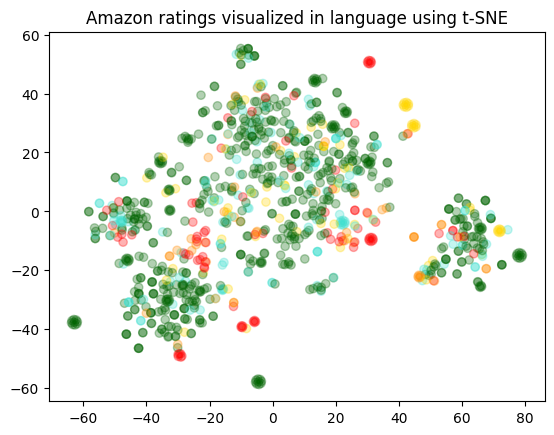

In [36]:
# 创建一个基于预定义颜色的颜色映射对象
colormap = matplotlib.colors.ListedColormap(colors)
# 使用 matplotlib 创建散点图，其中颜色由颜色映射对象和颜色索引共同决定，alpha 是点的透明度
plt.scatter(x, y, c=color_indices, cmap=colormap, alpha=0.3)

# 为图形添加标题
plt.title("Amazon ratings visualized in language using t-SNE")

**t-SNE降维后，评论大致分为3个大类。**

In [37]:
# 导入必要的库
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib

In [38]:
# 1. 准备数据
# 将embedding向量转换为numpy数组
matrix = np.vstack(df_embedded['embedding_vec'].values)

# 2. 使用t-SNE进行降维
tsne = TSNE(
    n_components=2,     # 降至2维
    random_state=42,    # 设置随机种子
    perplexity=30,      # 困惑度参数
    n_iter=1000         # 迭代次数
)
vis_dims = tsne.fit_transform(matrix)




/root/miniconda3/envs/langchain/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


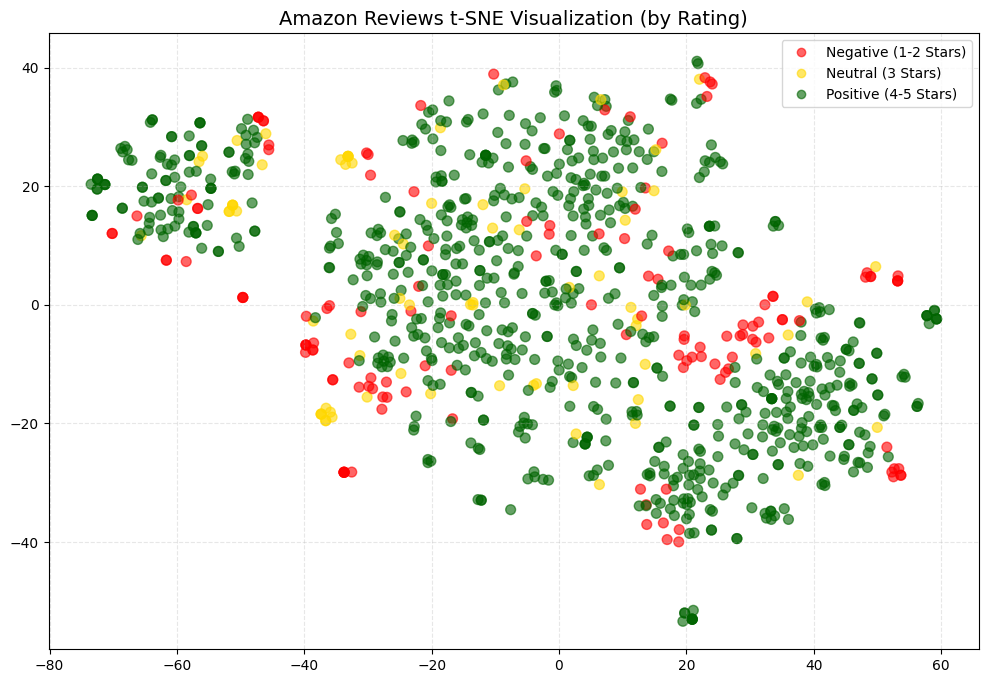

In [39]:
# 3. 可视化
# 根据评分设置颜色（1-2分为负面，3分为中性，4-5分为正面）
colors = ["red", "gold", "darkgreen"]
color_indices = np.where(df_embedded.Score <= 2, 0,
                        np.where(df_embedded.Score <= 3, 1, 2))

# 创建图形
plt.figure(figsize=(12, 8))

# 创建颜色映射
colormap = matplotlib.colors.ListedColormap(colors)

# 绘制散点图
scatter = plt.scatter(
    vis_dims[:, 0], 
    vis_dims[:, 1], 
    c=color_indices,
    cmap=colormap,
    alpha=0.6,
    s=50
)

# 添加图形元素 - 使用英文标题和图例
plt.title("Amazon Reviews t-SNE Visualization (by Rating)", fontsize=14)
plt.legend(
    handles=scatter.legend_elements()[0],
    labels=["Negative (1-2 Stars)", "Neutral (3 Stars)", "Positive (4-5 Stars)"],
    fontsize=10
)
plt.grid(True, linestyle='--', alpha=0.3)
# 显示图形
plt.show()


In [41]:
# 4. 打印各类别的统计信息
print("\n评论分布统计：")
print(f"负面评论 (1-2星): {sum(df_embedded.Score <= 2)} 条")
print(f"中性评论 (3星): {sum(df_embedded.Score == 3)} 条")
print(f"正面评论 (4-5星): {sum(df_embedded.Score >= 4)} 条")

# 5. 打印每个类别的示例评论（可选）
print("\n各类别示例评论：")
categories = [
    (df_embedded.Score <= 2, "负面评论"),
    (df_embedded.Score == 3, "中性评论"),
    (df_embedded.Score >= 4, "正面评论")
]

for mask, category in categories:
    print(f"\n{category}示例：")
    sample_reviews = df_embedded[mask]['combined'].sample(n=2)
    for review in sample_reviews:
        print(f"- {review[:200]}...")


评论分布统计：
负面评论 (1-2星): 136 条
中性评论 (3星): 75 条
正面评论 (4-5星): 789 条

各类别示例评论：

负面评论示例：
- Title: I did not receive my order; Content: I placed my order through Amazon and after about 10 days inquired about my order because it had not shipped.  I received an email back from Starbucks that m...
- Title: defective device; Content: no instructions provided. Trap would not open. when trying to set the trap, cut my finger. It appears that the device was not bent. not sure since no instructions...

中性评论示例：
- Title: its delicious...; Content: I was surprised at how delicious these toasted chips are. They ship well with little damage. I have ordered them several times. Also they are very fresh. Not one bit ...
- Title: Good flavor, but a wet mess; Content: I got the teriyaki flavor and, while the flavor is good and the texture is also good once you get it into your mouth, it can be a mess getting it there.  A...

正面评论示例：
- Title: My favorite; Content: These are one of my favorite snacks.  I realize I

## 4. 使用 K-Means 聚类，然后使用 t-SNE 可视化

In [42]:
import numpy as np
# 从 scikit-learn中导入 KMeans 类。KMeans 是一个实现 K-Means 聚类算法的类。
from sklearn.cluster import KMeans

# np.vstack 是一个将输入数据堆叠到一个数组的函数（在垂直方向）。
# 这里它用于将所有的 ada_embedding 值堆叠成一个矩阵。
# matrix = np.vstack(df.ada_embedding.values)

# 定义要生成的聚类数。
n_clusters = 4

# 创建一个 KMeans 对象，用于进行 K-Means 聚类。
# n_clusters 参数指定了要创建的聚类的数量；
# init 参数指定了初始化方法（在这种情况下是 'k-means++'）；
# random_state 参数为随机数生成器设定了种子值，用于生成初始聚类中心。
# n_init=10 消除警告 'FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4'
kmeans = KMeans(n_clusters = n_clusters, init='k-means++', random_state=42, n_init=10)

# 使用 matrix（我们之前创建的矩阵）来训练 KMeans 模型。这将执行 K-Means 聚类算法。
kmeans.fit(matrix)

# kmeans.labels_ 属性包含每个输入数据点所属的聚类的索引。
# 这里，我们创建一个新的 'Cluster' 列，在这个列中，每个数据点都被赋予其所属的聚类的标签。
df_embedded['Cluster'] = kmeans.labels_

In [43]:
df_embedded['Cluster']

12     1
13     1
14     1
15     3
16     1
      ..
447    2
436    2
437    0
438    2
439    1
Name: Cluster, Length: 1000, dtype: int32

In [44]:
df_embedded.head(2)

,ProductId,UserId,Score,Summary,Text,combined,n_tokens,embedding,embedding_vec,Cluster
12,B000K8T3OQ,AK43Y4WT6FFR3,1,Broken in a million pieces,Chips were broken into small pieces. Problem i...,Title: Broken in a million pieces; Content: Ch...,120,"[-0.0005399271612986922, -0.004124758299440145...","[-0.0005399271612986922, -0.004124758299440145...",1
13,B0051C0J6M,AWFA8N9IXELVH,1,Deceptive description,On Oct 9 I ordered from a different vendor the...,Title: Deceptive description; Content: On Oct ...,157,"[0.0068963742814958096, 0.0167608093470335, -0...","[0.0068963742814958096, 0.0167608093470335, -0...",1


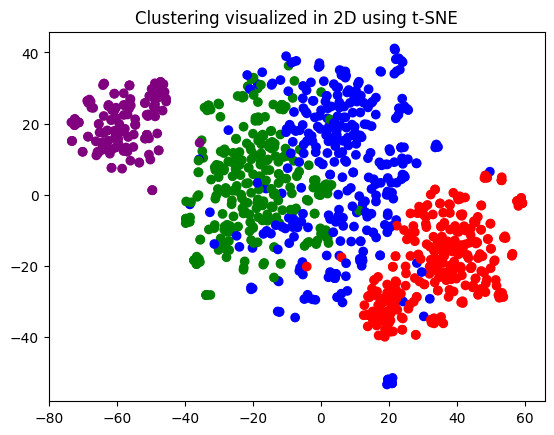

In [45]:
# 首先为每个聚类定义一个颜色。
colors = ["red", "green", "blue", "purple"]

# 然后，你可以使用 t-SNE 来降维数据。这里，我们只考虑 'embedding_vec' 列。
tsne_model = TSNE(n_components=2, random_state=42)
vis_data = tsne_model.fit_transform(matrix)

# 现在，你可以从降维后的数据中获取 x 和 y 坐标。
x = vis_data[:, 0]
y = vis_data[:, 1]

# 'Cluster' 列中的值将被用作颜色索引。
color_indices = df_embedded['Cluster'].values

# 创建一个基于预定义颜色的颜色映射对象
colormap = matplotlib.colors.ListedColormap(colors)

# 使用 matplotlib 创建散点图，其中颜色由颜色映射对象和颜色索引共同决定
plt.scatter(x, y, c=color_indices, cmap=colormap)

# 为图形添加标题
plt.title("Clustering visualized in 2D using t-SNE")

# 显示图形
plt.show()

**K-MEANS 聚类可视化效果，4类（官方介绍：一个专注于狗粮，一个专注于负面评论，两个专注于正面评论）。**

In [46]:
# 导入必要的库
import numpy as np
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib

/root/miniconda3/envs/langchain/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
/root/miniconda3/envs/langchain/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 35780 (\N{CJK UNIFIED IDEOGRAPH-8BC4}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/root/miniconda3/envs/langchain/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 35770 (\N{CJK UNIFIED IDEOGRAPH-8BBA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/root/miniconda3/envs/langchain/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 32858 (\N{CJK UNIFIED IDEOGRAPH-805A}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/root/miniconda3/envs/langchain/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 318

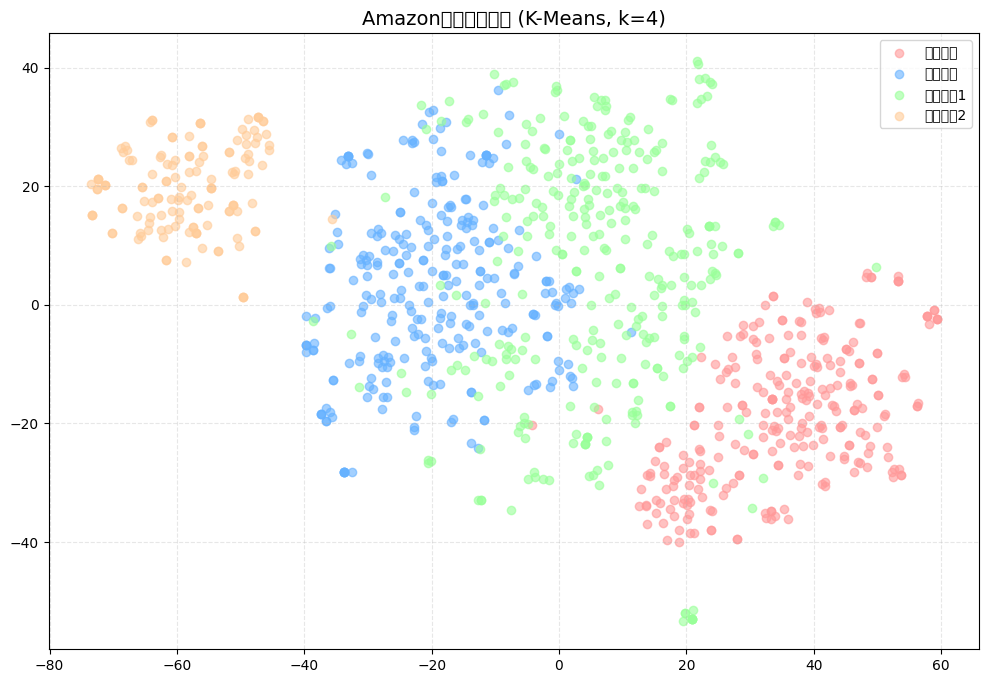


各聚类的示例评论：

狗粮相关的示例评论：
- Title: Arizona Green Tea with Pomegranate & Acai; Content: I love the convenience of the mail order process as I cannot locate this product in any super market in my area....
- Title: Rodeo Drive is Crazy Good Coffee!; Content: Rodeo Drive is my absolute favorite and I'm ready to order more!  That's if I can find it.<br />I don't know why they are discontinuing it.<br />It a...

负面评论的示例评论：
- Title: Yummy; Content: You can taste the butter.  The peanuts are fresh.  Each piece of See's Peanut Brittle is a nice size and the flavor is yummy.  If you are a prime member it ships at no additiona...
- Title: yummy; Content: the best matza balls out there- super yummy with salt. too bad they guy stopped selling them since it was the best price out there....

正面评论1的示例评论：
- Title: Love this faucet; Content: Love this faucet.  My husband had installed the same one in our old house so when our current faucet was leaking I told him not to fix it and we would buy the same on.

In [47]:
# 1. 准备数据
# 将embedding向量转换为numpy数组
matrix = np.vstack(df_embedded['embedding_vec'].values)

# 2. K-Means聚类
n_clusters = 4  # 设置4个聚类
kmeans = KMeans(
    n_clusters=n_clusters, 
    init='k-means++',  # 使用k-means++初始化方法
    random_state=42,   # 设置随机种子以确保结果可复现
    n_init=10         # 运行10次，选择最佳结果
)
kmeans.fit(matrix)  # 执行聚类
df_embedded['Cluster'] = kmeans.labels_  # 保存聚类结果

# 3. 使用t-SNE进行降维可视化
tsne = TSNE(
    n_components=2,    # 降至2维
    random_state=42,   # 设置随机种子
    perplexity=30,     # 困惑度参数
    n_iter=1000        # 迭代次数
)
vis_dims = tsne.fit_transform(matrix)

# 4. 可视化
# 设置聚类的颜色和标签
colors = ["#FF9999", "#66B2FF", "#99FF99", "#FFCC99"]  # 红、蓝、绿、橙
cluster_labels = ["狗粮相关", "负面评论", "正面评论1", "正面评论2"]

# 创建图形
plt.figure(figsize=(12, 8))

# 绘制散点图
for i in range(n_clusters):
    mask = df_embedded['Cluster'] == i
    plt.scatter(
        vis_dims[mask, 0], 
        vis_dims[mask, 1],
        c=colors[i],
        label=cluster_labels[i],
        alpha=0.6    # 设置透明度
    )

# 添加图形元素
plt.title("Amazon评论聚类分析 (K-Means, k=4)", fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.3)

# 显示图形
plt.show()

# 5. 打印每个聚类的示例评论（可选）
print("\n各聚类的示例评论：")
for i in range(n_clusters):
    print(f"\n{cluster_labels[i]}的示例评论：")
    sample_reviews = df_embedded[df_embedded['Cluster'] == i]['combined'].sample(n=2)
    for review in sample_reviews:
        print(f"- {review[:200]}...")

## 5. 使用 Embedding 进行文本搜索

![cosine](images/cosine.png)

In [48]:
# cosine_similarity 函数计算两个嵌入向量之间的余弦相似度
def cosine_similarity(a, b):
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

In [49]:
type(df_embedded["embedding_vec"][0])

list

In [50]:
# 定义搜索函数
def search_reviews(df, product_description, n=3, pprint=True):
    try:
        # 使用通义千问API获取查询文本的embedding
        product_embedding = embedding_text(
            product_description,
            model="text-embedding-v3"
        )
        
        # 检查向量维度
        first_vec = df.embedding_vec.iloc[0]
        print(f"数据库向量维度: {len(first_vec)}")
        print(f"查询向量维度: {len(product_embedding)}")
        
        # 如果维度不匹配，需要重新生成数据库中的embeddings
        if len(first_vec) != len(product_embedding):
            print("警告：向量维度不匹配，需要重新生成数据库embeddings")
            # 这里可以添加重新生成embeddings的代码
            return None
        
        # 计算余弦相似度
        df["similarity"] = df.embedding_vec.apply(lambda x: cosine_similarity(x, product_embedding))

        # 获取最相似的n条评论
        results = (
            df.sort_values("similarity", ascending=False)
            .head(n)
            .combined.str.replace("Title: ", "")
            .str.replace("; Content:", ": ")
        )
        
        # 打印结果
        if pprint:
            for r in results:
                print(r[:200])
                print()
        return results
        
    except Exception as e:
        print(f"发生错误: {str(e)}")
        return None

In [51]:
# 测试搜索功能前先重新生成embeddings
def regenerate_embeddings(df):
    print("重新生成embeddings...")
    df["embedding_vec"] = df.combined.apply(lambda x: embedding_text(x, model="text-embedding-v3"))
    return df

# 重新生成embeddings
df_embedded = regenerate_embeddings(df_embedded)

重新生成embeddings...


In [52]:
# 使用 'delicious beans' 作为产品描述和 3 作为数量，
# 调用 search_reviews 函数来查找与给定产品描述最相似的前3条评论。
# 其结果被存储在 res 变量中。
res = search_reviews(df_embedded, 'delicious beans', n=3)

数据库向量维度: 1024
查询向量维度: 1024
Good quality, fast delivery:  I bought these to make homemade vanilla.  The quality of beans was very good.  Very "meaty" and full of beans.  It was also received very quickly and they were well packa

Fantastic Instant Refried beans:  Fantastic Instant Refried Beans have been a staple for my family now for nearly 20 years.  All 7 of us love it and my grown kids are passing on the tradition.

Plump, juicy vanilla beans:  These are plump, juicy vanilla beans! Perfect for ice cream making and making vanilla extract. Very satisfied and will not buy expensive vanilla beans at the grocery store



In [53]:
res = search_reviews(df_embedded, 'dog food', n=3)

数据库向量维度: 1024
查询向量维度: 1024
Healthy Dog Food:  This is a very healthy dog food. Good for their digestion. Also good for small puppies. My dog eats her required amount at every feeding.

Paws up!:  We try different treats for our dogs and they seem to like the Holistic Select biscuits very much.  This has good quality ingredients just like their kibbles which our dogs like as well.

Paws up!:  We try different treats for our dogs and they seem to like the Holistic Select biscuits very much.  This has good quality ingredients just like their kibbles which our dogs like as well.



In [54]:
res = search_reviews(df_embedded, 'awful', n=5)

数据库向量维度: 1024
查询向量维度: 1024
God Awful:  As a dabbler who enjoys spanning the entire spectrum of taste, I am more than willing to try anything once.  Both as a food aficionado and a lover of bacon, I just had to pick this up.  On

Inedible:  I am one of the least picky eaters that I know, but I had to throw my bowl out after a few spoons of this.  It was disgusting and inedible.  I wonder if anyone at these big companies try th

Just Bad:  Watery and unpleasant.  Like Yoohoo mixed with dirty dish water.  I find it quite odd that Keurig would release a product like this.  I'm sure they can come up with a decent hot chocolate a

bot very cheesy:  Got this about a month ago.first of all it smells horrible...it tastes very peppery and not very cheesy. If you are going for the stuff at the movie theater this is not it

New Recipe is Awful:  These used to be my favorite animal crackers but Austin has recently changed their recipe to a "new and improved" version and as a result, what was once a

In [55]:
def search_reviews(df, product_description, n=3, pprint=True):
    product_embedding = embedding_text(product_description)

    df["similarity"] = df.embedding_vec.apply(lambda x: cosine_similarity(x, product_embedding))

    results = (
        df.sort_values("similarity", ascending=False)
        .head(n)
        .combined.str.replace("Title: ", "")
        .str.replace("; Content:", ": ")
    )
    if pprint:
        for r in results:
            print(r[:200])
            print()
    return results

res = search_reviews(df_embedded, 'dog food', n=3)

Healthy Dog Food:  This is a very healthy dog food. Good for their digestion. Also good for small puppies. My dog eats her required amount at every feeding.

Paws up!:  We try different treats for our dogs and they seem to like the Holistic Select biscuits very much.  This has good quality ingredients just like their kibbles which our dogs like as well.

Paws up!:  We try different treats for our dogs and they seem to like the Holistic Select biscuits very much.  This has good quality ingredients just like their kibbles which our dogs like as well.

